In [1]:
import matplotlib.pyplot as plt
import numpy as np 

from skpcp import PCP

In [2]:
RNG = np.random.default_rng(42)

## Example 1: Recovery of low-rank image corrupted by sparse noise

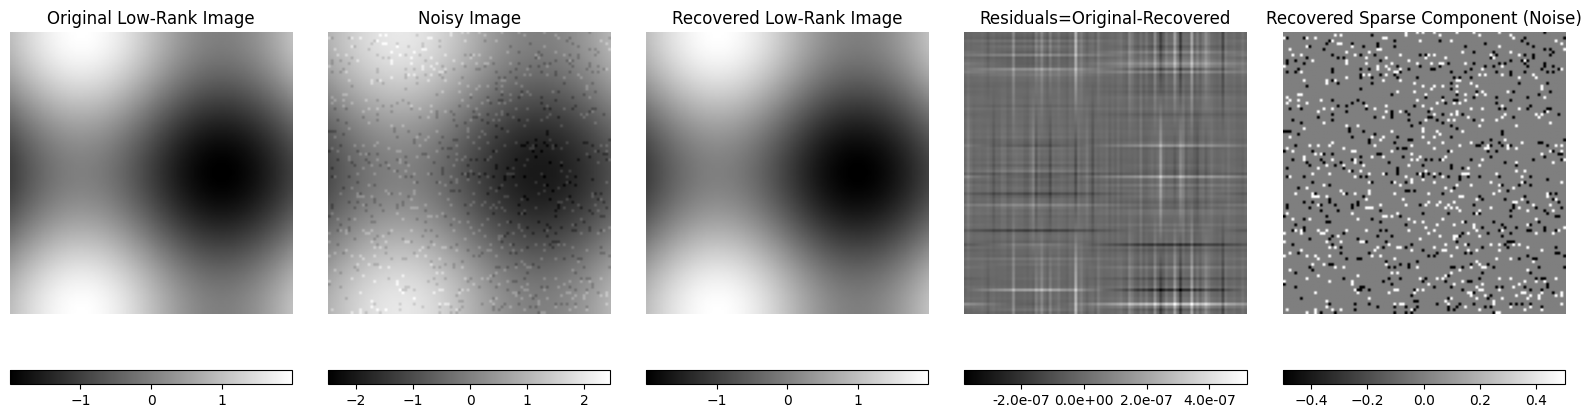

In [3]:
# Generate a synthetic image (low rank)
NROWS, NCOLS = 100, 100
NUM_OUTLIERS = 1000

X, Y = np.meshgrid(np.linspace(0, 1, NCOLS), np.linspace(0, 1, NROWS))
synthetic_image = np.sin(2 * np.pi * X) + np.cos(2 * np.pi * Y)

# Add sparse noise (random outliers)
sparse_noise = np.zeros_like(synthetic_image)
outlier_indices = RNG.choice(NROWS * NCOLS, size=NUM_OUTLIERS, replace=False)
sparse_noise.flat[outlier_indices] = RNG.choice([.5, -.5], size=NUM_OUTLIERS)

# Combine the low-rank image with the sparse noise
noisy_image = synthetic_image + sparse_noise
image_matrix = noisy_image.reshape(-1, noisy_image.shape[1])

# Apply principal component pursuit (PCP) to recover the low-rank and sparse components
pcp = PCP()
low_rank = pcp.fit_transform(image_matrix)
sparse = pcp.sparse_

low_rank_image = low_rank.reshape(noisy_image.shape)
sparse_image = sparse.reshape(noisy_image.shape)

# Plot the original, noisy, and recovered images
plt.figure(figsize=(16, 6))

title_list = [
    "Original Low-Rank Image",
    "Noisy Image",
    "Recovered Low-Rank Image",
    "Residuals=Original-Recovered",
    "Recovered Sparse Component (Noise)",
]
images_to_plot = [
    synthetic_image,
    noisy_image,
    low_rank_image,
    synthetic_image - low_rank_image,
    sparse_image,
]
for i, img in enumerate(images_to_plot, start=1):
    ax = plt.subplot(1, 5, i)
    im = ax.imshow(img, cmap="gray")
    plt.axis("off")
    title = title_list[i-1]
    plt.title(title)
    if title == "Residuals=Original-Recovered":
        plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.1, fraction=0.05, format="%1.1e", spacing="proportional")
    else:
        plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.1, fraction=0.05)
plt.axis("off")

plt.tight_layout()
plt.show()

## Example 2: Recovery of low-rank image corrupted by sparse noise

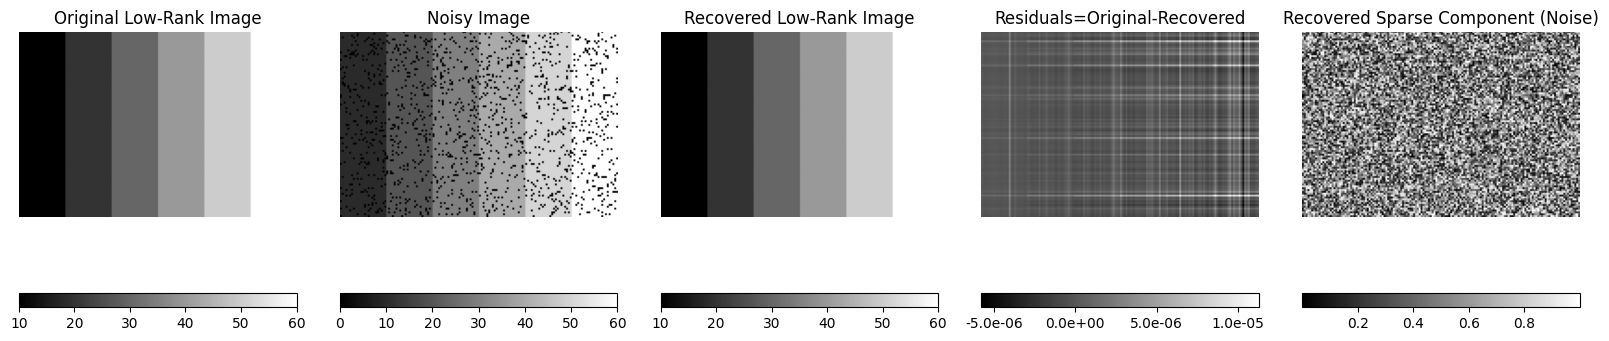

In [4]:
NROWS, NCOLS = 100, 150
NUM_GROUPS = 6
P_MISSING = 0.1

data = []
for k in range(NUM_GROUPS):
    d = np.ones((NROWS, NCOLS // NUM_GROUPS)) * (k + 1) * 10
    data.append(d)
data = np.hstack(data)

# DECIMATE 20% of data 
n1, n2 = data.shape
S = RNG.random((n1, n2))
data_corrupt = data.copy()
data_corrupt[S < P_MISSING] = 0

# Apply PCP to recover the low-rank and sparse components

pcp = PCP()
low_rank = pcp.fit_transform(data_corrupt)
sparse = pcp.sparse_

plt.figure(figsize=(16, 8))
images_to_plot = [
    data,
    data_corrupt,
    low_rank,
    data - low_rank,
    S,
]
title_list = [
    "Original Low-Rank Image",
    "Noisy Image",
    "Recovered Low-Rank Image",
    "Residuals=Original-Recovered",
    "Recovered Sparse Component (Noise)",
]
for i, img in enumerate(images_to_plot, start=1):
    ax = plt.subplot(1, 5, i)
    im = ax.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(title_list[i - 1])
    if title_list[i-1] == "Residuals=Original-Recovered":
        plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.1, fraction=0.046, format="%.1e")
    else:
        plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.1, fraction=0.046)

plt.axis("off")
plt.tight_layout()
plt.show()

## Example 3: Recovery of time series data corrupted by random spikes

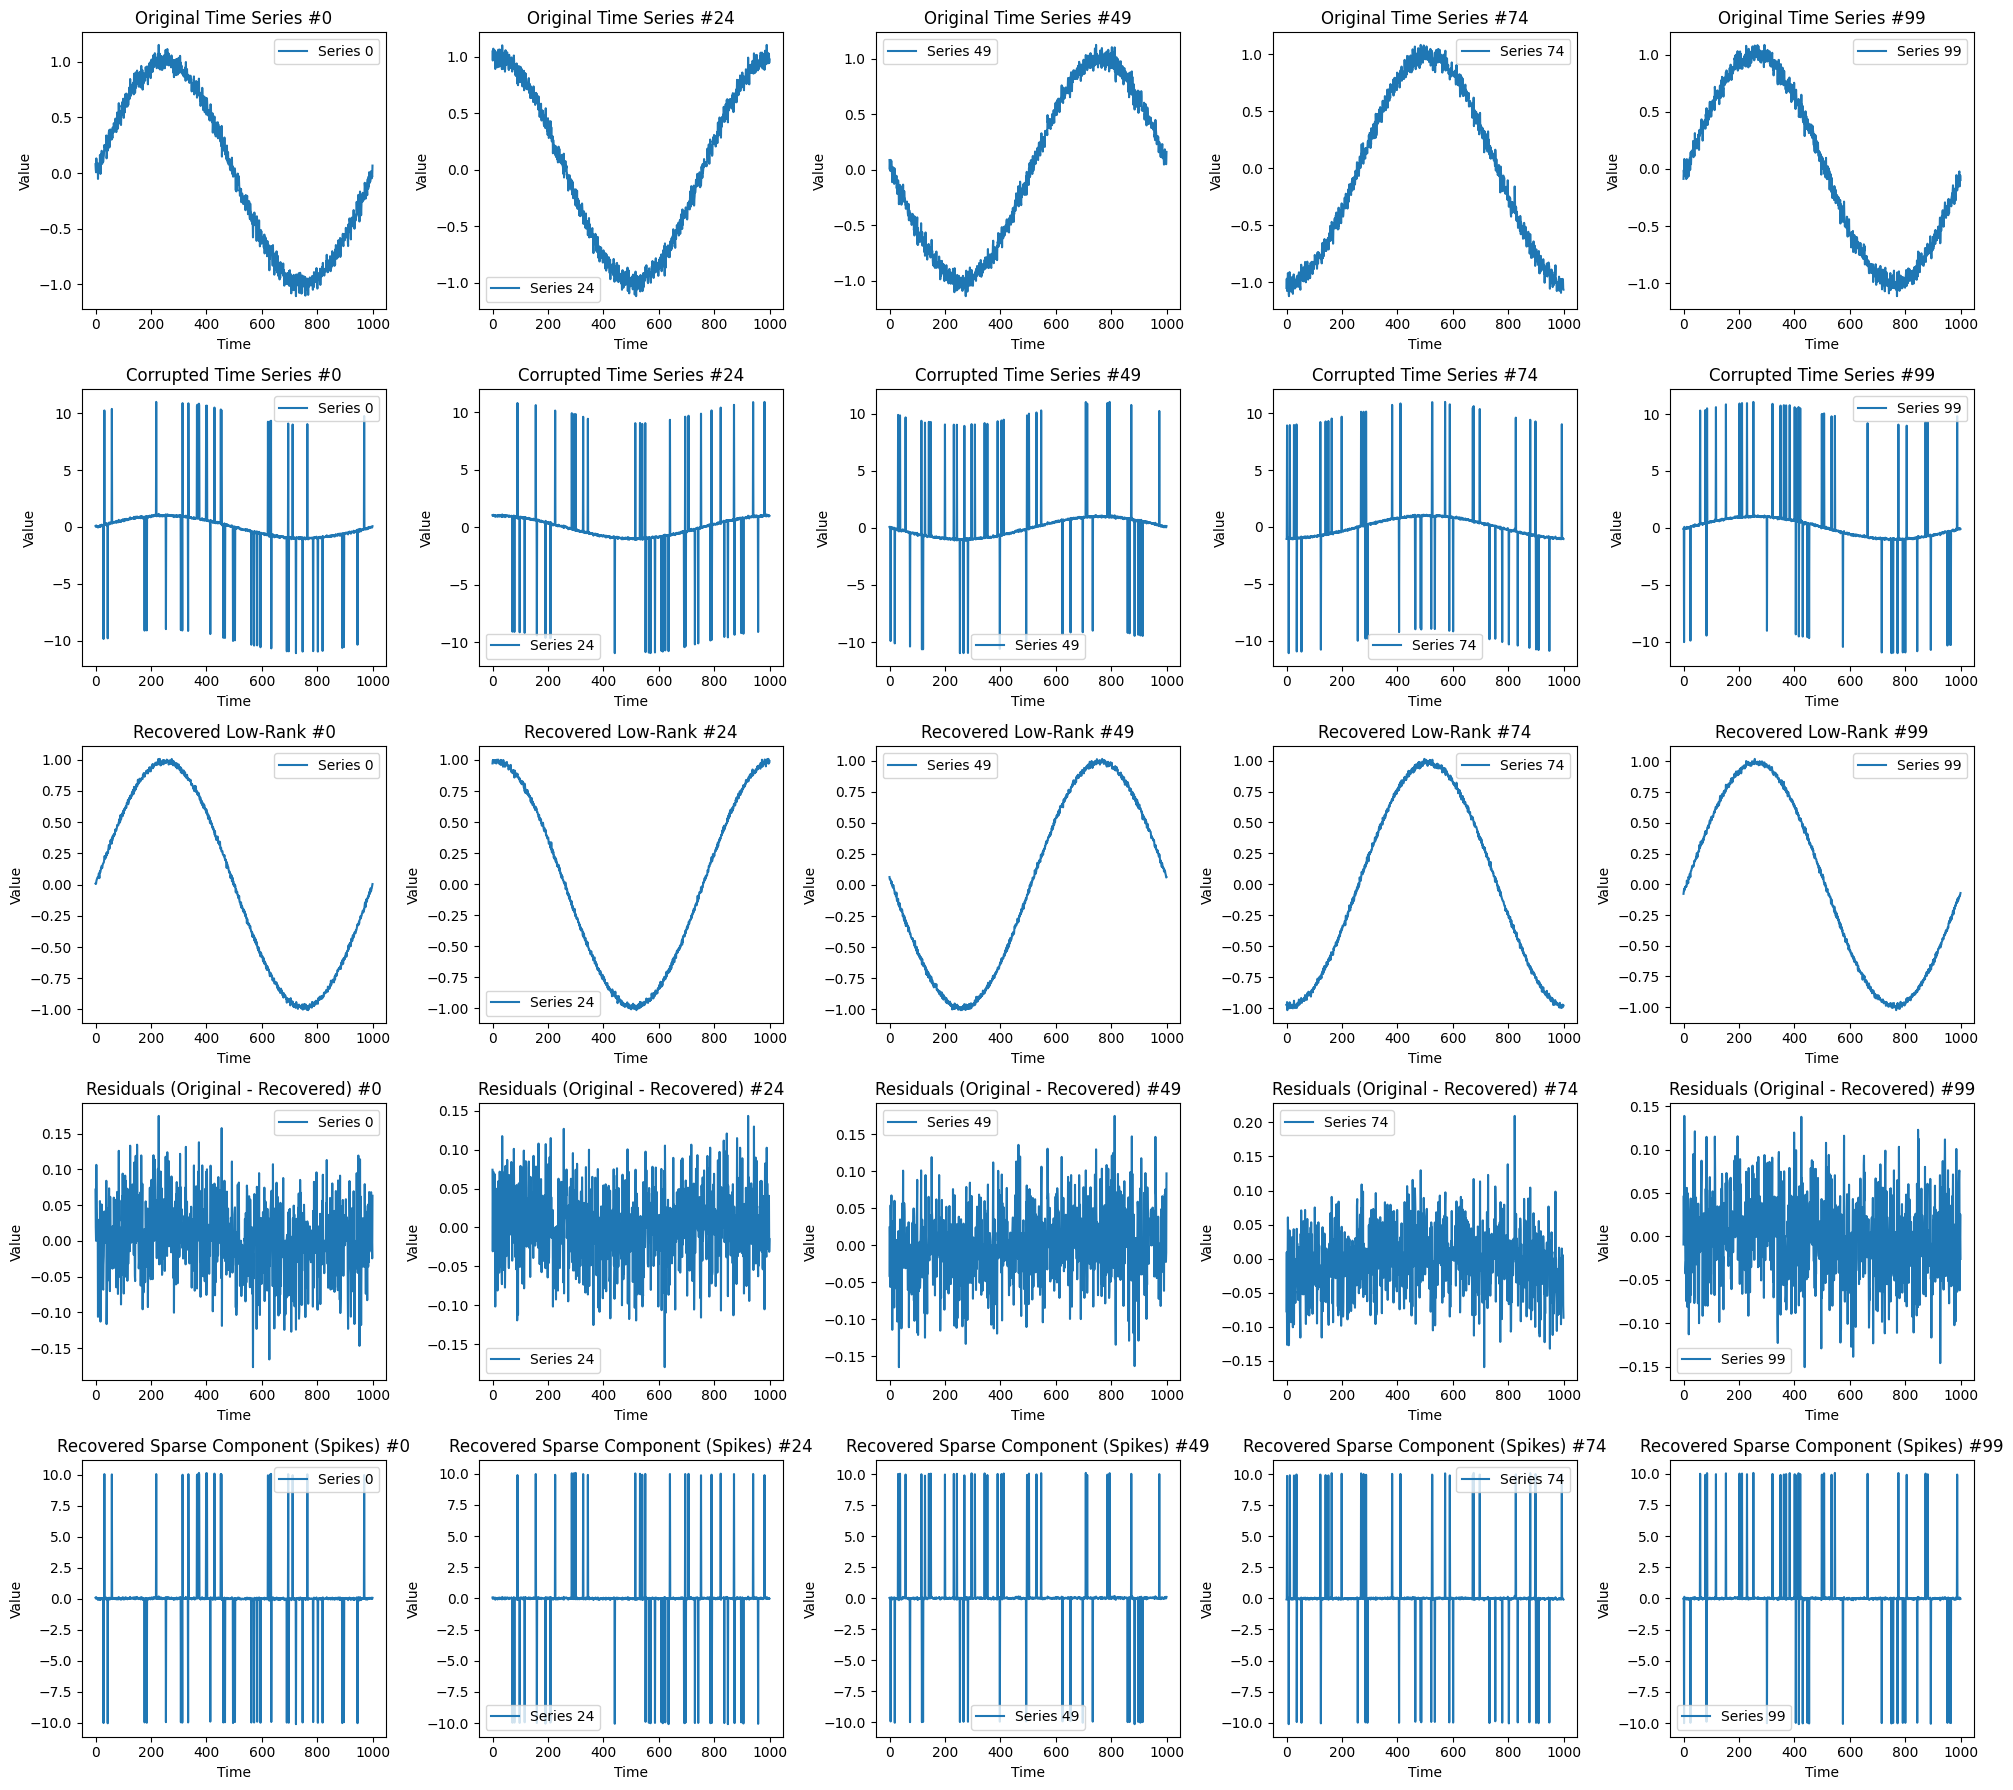

In [5]:


# Generate 100 time series of length 1000 from a normal distribution
num_series = 100
series_length = 1000
num_spikes = 50

phases = np.linspace(0, 2 * np.pi, num_series, endpoint=False)
time = np.arange(series_length)
time_series = np.array([
    np.sin(2 * np.pi * time / series_length + phase) + RNG.normal(0, 0.05, series_length)
    for phase in phases
])

# Add spikes (outliers) to each time series
corrupted_series = time_series.copy()
for i in range(num_series):
    spike_indices = RNG.choice(series_length, size=num_spikes, replace=False)
    corrupted_series[i, spike_indices] += RNG.choice([10, -10], size=num_spikes)

# Apply PCP to recover low-rank and sparse components
pcp = PCP()
low_rank = pcp.fit_transform(corrupted_series)
sparse = pcp.sparse_

# Select 5 time series to plot
selected_idx = np.linspace(0, num_series - 1, 5, dtype=int)

fig, axes = plt.subplots(5, 5, figsize=(20, 18))
panel_titles = [
    "Original Time Series",
    "Corrupted Time Series",
    "Recovered Low-Rank",
    "Residuals (Original - Recovered)",
    "Recovered Sparse Component (Spikes)",
]
time = np.arange(series_length)
for row, idx in enumerate(selected_idx):
    axes[0, row].plot(time, time_series[idx], label=f"Series {idx}")
    axes[0, row].set_title(panel_titles[0] + f" #{idx}")
    axes[0, row].legend()
    axes[0, row].set_xlabel("Time")
    axes[0, row].set_ylabel("Value")

    axes[1, row].plot(time, corrupted_series[idx], label=f"Series {idx}")
    axes[1, row].set_title(panel_titles[1] + f" #{idx}")
    axes[1, row].legend()
    axes[1, row].set_xlabel("Time")
    axes[1, row].set_ylabel("Value")

    axes[2, row].plot(time, low_rank[idx], label=f"Series {idx}")
    axes[2, row].set_title(panel_titles[2] + f" #{idx}")
    axes[2, row].legend()
    axes[2, row].set_xlabel("Time")
    axes[2, row].set_ylabel("Value")

    axes[3, row].plot(time, time_series[idx] - low_rank[idx], label=f"Series {idx}")
    axes[3, row].set_title(panel_titles[3] + f" #{idx}")
    axes[3, row].legend()
    axes[3, row].set_xlabel("Time")
    axes[3, row].set_ylabel("Value")

    axes[4, row].plot(time, sparse[idx], label=f"Series {idx}")
    axes[4, row].set_title(panel_titles[4] + f" #{idx}")
    axes[4, row].legend()
    axes[4, row].set_xlabel("Time")
    axes[4, row].set_ylabel("Value")

plt.tight_layout()
plt.show()